<a href="https://colab.research.google.com/github/LaJeremi/Tensorflow-nlp-tutorial-Practice-/blob/main/11_03_imdb_review_sentiment_analysis_using_cnn_(1D_CNN%EC%9C%BC%EB%A1%9C_IMDB_%EB%A6%AC%EB%B7%B0_%EB%B6%84%EB%A5%98).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 11_03. imdb_review_sentiment_analysis_using_cnn (1D CNN으로 IMDB 리뷰 분류)

출처: https://wikidocs.net/80783


# 1. 데이터에 대한 전처리

In [1]:

import tensorflow as tf
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
tf.__version__


'2.11.0'

최대 10,000개의 단어만을 허용하여 데이터를 로드

In [3]:
vocab_size = 10000
(X_train, y_train), (X_test, y_test) = datasets.imdb.load_data(num_words=vocab_size)

17464789/17464789 [==============================] - 0s 0us/step


In [4]:
print(X_train[:5])


[list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32])
 list([1, 194, 1153, 194, 8255, 78, 228, 5, 6, 1463, 

In [5]:
print(y_train[:5])


[1 0 0 1 0]


 각 샘플은 이미 정수 인코딩까지 전처리가 된 상태

  패딩을 진행하여 모든 샘플들의 길이를 200으로 맞춥니다.

In [6]:
max_len = 200
X_train = pad_sequences(X_train, maxlen=200)
X_test = pad_sequences(X_test, maxlen=200)

패딩이 되었는지 크기(shape)

In [7]:
print('X_train의 크기(shape) :',X_train.shape)
print('X_test의 크기(shape) :',X_test.shape)

X_train의 크기(shape) : (25000, 200)
X_test의 크기(shape) : (25000, 200)


훈련 데이터, 테스트 데이터 각 25,000 샘플이 전부 길이 200을 가지는 것을 확인할 수 있습니다. 

y_train도 출력

In [8]:
print(y_train[:5])


[1 0 0 1 0]


# 2. 1D CNN으로 IMDB 리뷰 분류하기

*  1D CNN 모델을 설계

하이퍼파라미터인 임베딩 벡터의 차원은 256,

드롭 아웃 비율은 0.3, 

커널의 크기는 3, 

해당 커널은 총 256개 사용

합성곱 층과 맥스풀링 연산 후 전결합층(Fully Connected Layer)을 은닉층을 추가로 사용

은닉층의 뉴런 수는 128


* 이진 분류 문제의 경우,

 출력층에 로지스틱 회귀를 사용해야 하므로 
 
 활성화 함수로는 시그모이드 함수를 사용하고, 
 
 손실 함수로 크로스 엔트로피 함수를 사용합니다. 
 
 20 에포크를 수행

-----

EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)는 검증 데이터 손실(val_loss)이 증가

과적합 징후므로 검증 데이터 손실이 3회 증가하면 정해진 에포크가 도달하지 못하였더라도 학습을 조기 종료(Early Stopping)

ModelCheckpoint를 사용하여 검증 데이터의 정확도(val_acc)가 이전보다 좋아질 경우에만 모델을 저장

validation_data로는 X_test와 y_test를 사용합니다. val_loss가 줄어들다가 증가하는 상황이 오면 과적합으로 판단하기 위함


In [10]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [11]:
model = Sequential()
model.add(Embedding(vocab_size, 256))
model.add(Dropout(0.3))
model.add(Conv1D(256, 3, padding='valid', activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

In [12]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 256)         2560000   
                                                                 
 dropout (Dropout)           (None, None, 256)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 256)         196864    
                                                                 
 global_max_pooling1d (Globa  (None, 256)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                        

In [13]:

es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)
mc = ModelCheckpoint('best_model.h5', monitor = 'val_acc', mode = 'max', verbose = 1, save_best_only = True)

In [14]:
model.compile(optimizer='adam', loss = 'binary_crossentropy', metrics = ['acc'])
history = model.fit(X_train, y_train, epochs = 20, validation_data = (X_test, y_test), callbacks=[es, mc])

Epoch 1/20
782/782 [==============================] - ETA: 0s - loss: 0.4167 - acc: 0.7944
Epoch 1: val_acc improved from -inf to 0.85428, saving model to best_model.h5
782/782 [==============================] - 234s 297ms/step - loss: 0.4167 - acc: 0.7944 - val_loss: 0.3414 - val_acc: 0.8543
Epoch 2/20
782/782 [==============================] - ETA: 0s - loss: 0.2205 - acc: 0.9135
Epoch 2: val_acc improved from 0.85428 to 0.88780, saving model to best_model.h5
782/782 [==============================] - 227s 291ms/step - loss: 0.2205 - acc: 0.9135 - val_loss: 0.2659 - val_acc: 0.8878
Epoch 3/20
782/782 [==============================] - ETA: 0s - loss: 0.1114 - acc: 0.9598
Epoch 3: val_acc did not improve from 0.88780
782/782 [==============================] - 225s 287ms/step - loss: 0.1114 - acc: 0.9598 - val_loss: 0.3532 - val_acc: 0.8680
Epoch 4/20
782/782 [==============================] - ETA: 0s - loss: 0.0460 - acc: 0.9852
Epoch 4: val_acc did not improve from 0.88780
782/782 [=

저자의 경우 에포크 5에서 조기 종료

저장된 모델을 로드하여 테스트 정확도를 확인

In [15]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

782/782 [==============================] - 42s 54ms/step - loss: 0.2659 - acc: 0.8878

 테스트 정확도: 0.8878


89.13%의 정확도

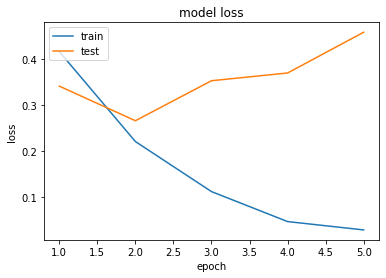

In [16]:

import matplotlib.pyplot as plt
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()